# Preprocessing

## imports

In [251]:
import pandas as pd
import numpy as np
import datetime
# import python_ta as pta
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error

## constants

In [4]:
main_directory_crypto = 'klines/crypto/'

## helpers

In [249]:
def wwma(values, n):
    """
     J. Welles Wilder's EMA
    """
    return values.ewm(alpha=1 / n, adjust=False).mean()

def percentage(f, t):
    return round((t/f - 1) * 100, 2)
    
def upwick(d):
    return percentage(max(d['open'], d['close']), d['high'])

def downwick(d):
    return percentage(min(d['open'], d['close']), d['high'])

# body

# range

def vwma(prices, volumes, window):
    """
    Calculate the Volume Weighted Moving Average (VWMA).
    
    Parameters:
        prices (pandas.Series): Series of prices.
        volumes (pandas.Series): Series of volumes.
        window (int): Window size for the moving average.
    
    Returns:
        pandas.Series: Volume Weighted Moving Average (VWMA) values.
    """
    # Calculate typical price
    typical_price = (prices * volumes).sum() / volumes.sum()
    
    # Calculate VWMA
    vwma_values = pd.Series(index=prices.index)
    for i in range(len(prices) - window + 1):
        vwma_values.iloc[i + window - 1] = (prices.iloc[i:i+window] * volumes.iloc[i:i+window]).sum() / volumes.iloc[i:i+window].sum()
    
    return vwma_values

def generate_features(df):
    # SMA - Simple Moving Averages
    sma_periods = [10, 20, 50, 100, 200]
    for n in sma_periods:
        df['tmp'] = df['close'].rolling(window=n).mean()
        df[f'f_sma_{n}'] = percentage(df['tmp'], df['close'])

    # EMA - Exponential Moving Averages
    ema_periods = [10, 20, 50, 100, 200]
    for n in ema_periods:
        df['tmp'] = df['close'].ewm(span=n, adjust=False).mean()
        df[f'f_ema_{n}'] = percentage(df['tmp'], df['close'])

    # ATR - Average True Range
    atr_periods = [7,10,14,20,30]
    df['tr0'] = abs(df['high'] - df['low'])
    df['tr1'] = abs(df['high'] - df['close'].shift())
    df['tr2'] = abs(df['low'] - df['close'].shift())
    df['tr'] = df[['tr0', 'tr1', 'tr2']].max(axis=1)
    df.drop(['tr0', 'tr1','tr2'], axis=1, inplace=True)

    for n in atr_periods:
        df['tmp'] = wwma(df['tr'], n)
        df[f'f_atr_{n}'] = percentage(df['tmp'], df['tr'])
    df.drop('tr', axis=1, inplace=True)
    # df['f_atr_14'].apply(lambda x: np.log(x+100)-4.5).hist()

    # Candlestick info
    df['f_upwick'] = df.apply(upwick, axis=1)
    df['f_body'] = percentage(df['open'], df['close'])
    df['f_downwick'] = df.apply(downwick, axis=1)
    df['f_range'] = percentage(df['low'], df['high'])

    # SIMPLE VOLUME MOVING AVERAGE - [10,20,50]
    vma_periods = [10,20,50]
    for n in vma_periods:
        df['tmp'] = df['volume'].rolling(window=n).mean()
        df[f'f_vma_{n}'] = percentage(df['tmp'], df['volume'])
    

    # VWMA - Volume Weighted Moving Average
    vwma_periods = [10,20,50]
    for n in vwma_periods:
        df['tmp'] = vwma(df['close'], df['volume'], window=n)
        df[f'f_vwma_{n}'] = percentage(df['tmp'], df['close'])

    df.drop('tmp', axis=1, inplace=True)

    # 1-2-3 days ago features appended
    for col in df.columns:
        if not col.startswith('f'):
            continue    
        for i in range(1,4):
            df[f"{col}_{i}"] = df[col].shift(i)
        
    # Targets
    df['target_clf'] = (df['close'] >= df['close'].shift(1)).astype(int)
    df['target_clf'] = df['target_clf'].shift(-1)
    df['target_reg'] = percentage(df['close'].shift(1), df['close'])
    df['target_reg'] = df['target_reg'].shift(-1)
    
    
    return df

## test one ticker

In [250]:
s = 'INJBTC'
folder = s[0]
path = os.path.join(main_directory_crypto,folder,s + '.csv')
path

df = pd.read_csv(path)
df.sort_values('time', inplace=True)
df.drop_duplicates(inplace=True) # mostly stock data have duplicates
df = generate_features(df)
for col in df.columns:
    if not col.startswith('f'):
        continue    
    for i in range(1,4):
        df[f"{col}_{i}"] = df[col].shift(i)


df.dropna(inplace=True)

df

/var/folders/6w/2zf1qgfd4dqg3bs98bn50z4m0000gn/T/ipykernel_84124/3836025416.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  vwma_values = pd.Series(index=prices.index)
/var/folders/6w/2zf1qgfd4dqg3bs98bn50z4m0000gn/T/ipykernel_84124/3319185808.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_{i}"] = df[col].shift(i)


,time,open,high,low,close,volume,f_sma_10,f_sma_20,f_sma_50,f_sma_100,...,f_vwma_20_3_3,f_vwma_50_1_1,f_vwma_50_1_2,f_vwma_50_1_3,f_vwma_50_2_1,f_vwma_50_2_2,f_vwma_50_2_3,f_vwma_50_3_1,f_vwma_50_3_2,f_vwma_50_3_3
205,2021-12-07,0.000192,0.000196,0.000182,0.000182,27.84,-13.82,-14.76,-9.26,-15.03,...,5.40,-2.45,5.92,8.30,5.92,8.30,8.17,8.30,8.17,9.81
206,2021-12-08,0.000183,0.000191,0.000181,0.000190,14.36,-9.41,-11.39,-5.45,-11.38,...,3.37,-5.83,-2.45,5.92,-2.45,5.92,8.30,5.92,8.30,8.17
207,2021-12-09,0.000190,0.000192,0.000177,0.000178,15.19,-13.71,-16.74,-11.28,-16.84,...,3.01,-10.26,-5.83,-2.45,-5.83,-2.45,5.92,-2.45,5.92,8.30
208,2021-12-10,0.000178,0.000275,0.000176,0.000197,189.33,-2.39,-7.91,-1.56,-7.45,...,0.54,-6.53,-10.26,-5.83,-10.26,-5.83,-2.45,-5.83,-2.45,5.92
209,2021-12-11,0.000197,0.000201,0.000185,0.000188,32.39,-5.33,-11.77,-6.01,-11.51,...,-7.76,-12.40,-6.53,-10.26,-6.53,-10.26,-5.83,-10.26,-5.83,-2.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022,2024-03-03,0.000689,0.000695,0.000620,0.000645,41.97,-5.27,-6.22,-15.60,-12.69,...,-4.35,-7.29,-14.72,-12.80,-14.72,-12.80,-13.11,-12.80,-13.11,-17.79
1023,2024-03-04,0.000646,0.000656,0.000575,0.000594,52.18,-11.99,-12.92,-21.62,-19.68,...,-0.00,-10.76,-7.29,-14.72,-7.29,-14.72,-12.80,-14.72,-12.80,-13.11
1024,2024-03-05,0.000594,0.000647,0.000544,0.000590,68.55,-11.48,-12.88,-21.34,-20.34,...,-0.93,-15.80,-10.76,-7.29,-10.76,-7.29,-14.72,-7.29,-14.72,-12.80
1025,2024-03-06,0.000592,0.000598,0.000556,0.000588,53.15,-10.36,-12.71,-20.84,-20.74,...,-3.72,-21.57,-15.80,-10.76,-15.80,-10.76,-7.29,-10.76,-7.29,-14.72


## all files

In [252]:
def file_list(source):
    res = []
    for root, dirnames, filenames in os.walk(source):
        for filename in filenames:
            if filename.endswith('.csv'):
                res.append(os.path.join(root, filename))
    return res
all_files = file_list(main_directory_crypto)

# ['klines/crypto/R/RUNEUSDT.csv', ..]
len(all_files)

939

## Train, test (BTC) pairs

In [323]:
def get_all_df():
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    for file in tqdm(all_files):
        symbol = file.split('/')[-1].split('.')[0]
        if 'DOWN' in symbol:
            continue
        # if not symbol.endswith('USDT'):
        #     continue
        df = pd.read_csv(file)
        df['symbol'] = symbol
        df.sort_values('time', inplace=True)
        
        shape_before = df.shape[0]
        df.drop_duplicates(inplace=True) # mostly stock data have duplicates
        shape_after = df.shape[0] 
        
        diff = shape_before - shape_after
        if diff > 0:
            print(f"{symbol} - {diff} duplicates")
        df = generate_features(df)
        
        X_test = pd.concat([X_test, df.tail(1)])
        
        df.dropna(inplace=True)
        if not df.empty:
            # df.drop(['time', 'open', 'high', 'low','close','volume'], axis=1, inplace=True)
            # df.drop(['open', 'high', 'low'], axis=1, inplace=True)
            X_train = pd.concat([X_train, df])
    
    return X_train, X_test

df_train, df_test = get_all_df()


# df_test.dropna(inplace=True)

  0%|                                                                                                                                                                                                              | 0/939 [00:00<?, ?it/s]/var/folders/6w/2zf1qgfd4dqg3bs98bn50z4m0000gn/T/ipykernel_84124/3836025416.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  vwma_values = pd.Series(index=prices.index)
 42%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 395/939 [02:38<04:22,  2.07it/s]/var/folders/6w/2zf1qgfd4dqg3bs98bn50z4m0000gn/T/ipykernel_84124/3836025416.py:38: RuntimeWarning: invalid value encountered in scalar divide
  vwma_values.iloc[i + window - 1] = (prices.iloc[i:i+window] * volumes.iloc[i:i+window]).sum

In [324]:
df_train.reset_index(drop=True, inplace=True)

# Latest day data for prediction to tomorrow
max_time = df_test['time'].mode()[0]
df_test = df_test[df_test['time'] == max_time].reset_index(drop=True)

ind = df_tmp[[x for x in df_tmp.columns if x.startswith('f')]].dropna().index.values
df_test = df_test.iloc[ind]

# yesterday data for validation
yesterday = (datetime.datetime.strptime(max_time, '%Y-%m-%d') - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
df_yesterday = df_train[df_train['time'] == yesterday]
df_train = df_train.drop(index=df_yesterday.index)

In [325]:
df_train.shape, df_test.shape, df_yesterday.shape

((546956, 109), (605, 109), (605, 109))

# EDA

## Transform data

In [331]:
features_cols = [x for x in df_train.columns if x.startswith('f')]

In [332]:
def transform(df):
    
    for col in features_cols + ['target_reg']:
        df[col] = df[col].apply(lambda x: np.log1p(abs(x)) * (-1 if x < 0 else 1))
    return df
# transform target
# t['target_reg'] = t['target_reg'].apply(lambda x: np.log1p(abs(x)) * (-1 if x < 0 else 1))

# To transform back
# t['f_sma_10_exp'] = t['f_sma_10_log'].apply(lambda x: np.expm1(abs(x)) * (-1 if x < 0 else 1))

In [338]:
for df in [df_train, df_yesterday, df_test]:
    df = transform(df)

In [341]:
df_train[features_cols].describe()

,f_sma_10,f_sma_20,f_sma_50,f_sma_100,f_sma_200,f_ema_10,f_ema_20,f_ema_50,f_ema_100,f_ema_200,...,f_vma_50_3,f_vwma_10_1,f_vwma_10_2,f_vwma_10_3,f_vwma_20_1,f_vwma_20_2,f_vwma_20_3,f_vwma_50_1,f_vwma_50_2,f_vwma_50_3
count,546956.000000,546956.000000,546956.000000,546956.000000,546956.000000,546956.000000,546956.000000,546956.000000,546956.000000,546956.000000,...,546956.000000,546956.000000,546956.000000,546956.000000,546956.000000,546956.000000,546956.000000,546956.000000,546956.000000,546956.000000
mean,-0.209125,-0.346027,-0.650853,-0.959128,-1.454570,-0.268277,-0.438481,-0.788257,-1.211084,-1.862517,...,-1.581319,-0.478708,-0.478362,-0.479344,-0.735683,-0.735883,-0.737059,-1.198976,-1.199983,-1.201641
std,1.743694,2.056002,2.443496,2.684779,2.854440,1.619260,1.921619,2.286677,2.502373,2.584878,...,3.646494,1.660192,1.659991,1.659161,1.933481,1.933157,1.932066,2.241897,2.241264,2.239936
min,-4.615121,-4.615121,-4.615121,-4.615121,-4.615121,-4.615121,-4.615121,-4.615121,-4.615121,-4.615121,...,-4.615121,-4.615121,-4.615121,-4.615121,-4.615121,-4.615121,-4.615121,-4.615121,-4.615121,-4.615121
25%,-1.682688,-2.107786,-2.666534,-3.080533,-3.531055,-1.599388,-2.021548,-2.603430,-3.074081,-3.578786,...,-4.179910,-1.850028,-1.850028,-1.850028,-2.317474,-2.317474,-2.317474,-2.906901,-2.907447,-2.907447
50%,-0.576613,-1.004302,-1.738710,-2.271094,-2.899221,-0.641854,-1.081805,-1.778336,-2.385086,-3.040228,...,-3.670461,-0.904218,-0.900161,-0.904218,-1.413423,-1.413423,-1.415853,-2.173615,-2.173615,-2.173615
75%,1.355835,1.617406,1.830980,1.813195,1.095273,1.160021,1.363537,1.460938,1.081805,-1.335001,...,2.270062,1.057790,1.057790,1.054312,1.121678,1.121678,1.118415,0.806476,0.802002,0.797507
max,6.177384,6.511225,6.675344,6.989685,7.269972,5.705315,6.175992,6.523107,6.730314,7.019967,...,8.425793,5.647988,5.647988,5.647988,4.927326,4.927326,4.927326,5.701747,5.701747,5.701747


In [342]:
df_train.head()

,time,open,high,low,close,volume,symbol,f_sma_10,f_sma_20,f_sma_50,...,f_vwma_10_2,f_vwma_10_3,f_vwma_20_1,f_vwma_20_2,f_vwma_20_3,f_vwma_50_1,f_vwma_50_2,f_vwma_50_3,target_clf,target_reg
0,2021-12-04,10.045,10.110,6.160,8.757,72023633.80,RUNEUSDT,-3.007167,-3.018960,-3.274121,...,-2.043814,-1.519513,-2.347558,-1.991976,-1.599388,-2.928524,-2.703373,-2.492379,0.0,-2.439735
1,2021-12-05,8.757,8.900,7.506,7.840,35609608.13,RUNEUSDT,-3.223664,-3.312730,-3.532226,...,-2.425687,-2.043814,-3.003204,-2.347558,-1.991976,-3.366261,-2.928524,-2.703373,0.0,-1.316408
2,2021-12-06,7.840,7.867,6.551,7.626,44443611.33,RUNEUSDT,-3.206398,-3.345332,-3.583797,...,-3.000720,-2.425687,-3.313095,-3.003204,-2.347558,-3.594019,-3.366261,-2.928524,0.0,-1.742219
3,2021-12-07,7.624,7.899,7.103,7.267,37394189.78,RUNEUSDT,-3.230014,-3.420346,-3.664331,...,-3.201933,-3.000720,-3.344274,-3.313095,-3.003204,-3.634159,-3.594019,-3.366261,1.0,2.469793
4,2021-12-08,7.270,8.053,7.033,8.053,33463305.63,RUNEUSDT,-2.658159,-3.104587,-3.477850,...,-3.141130,-3.201933,-3.424588,-3.344274,-3.313095,-3.704261,-3.634159,-3.594019,0.0,-2.652537


In [343]:
df_train.columns

Index(['time', 'open', 'high', 'low', 'close', 'volume', 'symbol', 'f_sma_10',
       'f_sma_20', 'f_sma_50',
       ...
       'f_vwma_10_2', 'f_vwma_10_3', 'f_vwma_20_1', 'f_vwma_20_2',
       'f_vwma_20_3', 'f_vwma_50_1', 'f_vwma_50_2', 'f_vwma_50_3',
       'target_clf', 'target_reg'],
      dtype='object', length=109)

<AxesSubplot: >

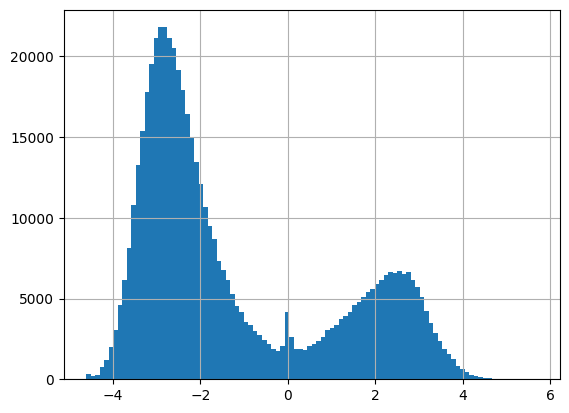

In [344]:
# Distribution check
df_train['f_vwma_50'].hist(bins=100)

# Catboost classifier

## Train test split data

In [346]:
X = df_train[features_cols]
y = df_train[['target_clf', 'target_reg']]
target_clf = 'target_clf'
target_reg = 'target_reg'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [348]:
# Catboost classifier
# jupyter nbextension enable --py widgetsnbextension
clf = CatBoostClassifier(iterations=1000, 
                         depth=6, 
                         learning_rate=0.1, 
                         loss_function='Logloss',
                         random_seed=42)
clf.fit(X_train, y_train[target_clf], eval_set=(X_test, y_test[target_clf]), verbose=False)

y_clf_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test[target_clf], y_clf_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.60


In [349]:
print(classification_report(y_clf_pred, y_test[target_clf]))

              precision    recall  f1-score   support

         0.0       0.64      0.60      0.62     59581
         1.0       0.56      0.60      0.58     49811

    accuracy                           0.60    109392
   macro avg       0.60      0.60      0.60    109392
weighted avg       0.60      0.60      0.60    109392



In [350]:
print(confusion_matrix(y_clf_pred, y_test[target_clf]))

[[35693 23888]
 [19892 29919]]


In [351]:
# Yesterday validation check
y_pred_yesterday = clf.predict(df_yesterday[features_cols])

In [352]:
accuracy = accuracy_score(df_yesterday[target_clf], y_pred_yesterday)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.55


In [355]:
print(confusion_matrix(y_pred_yesterday, df_yesterday[target_clf]))

[[180 114]
 [161 150]]


In [353]:
df_yesterday['pred_clf'] = y_pred_yesterday

# Regressor

In [358]:
# jupyter nbextension enable --py widgetsnbextension
reg = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, loss_function='RMSE', random_seed=42)
reg.fit(X_train[features_cols], y_train[target_reg], verbose=False)

y_reg_pred = reg.predict(X_test[features_cols])

mse = mean_squared_error(y_test[target_reg], y_reg_pred)
print(f'Mean Squared Error: {mse:.2f}')



Mean Squared Error: 1.78


In [359]:
# yesterday prediction
y_pred_yesterday = reg.predict(df_yesterday[features_cols])
mse = mean_squared_error(df_yesterday[target_reg], y_pred_yesterday)
print(f'Mean Squared Error: {mse:.2f}')


Mean Squared Error: 2.10


In [360]:
df_yesterday['pred_reg'] = y_pred_yesterday

# Validation check for yesterday predictions

In [365]:
df_yesterday = df_yesterday[((df_yesterday['pred_clf'] == 1) & (df_yesterday['pred_reg'] >= 0)) | ((df_yesterday['pred_clf'] == 0) & (df_yesterday['pred_reg'] < 0))]

In [367]:
accuracy = accuracy_score(df_yesterday[target_clf], df_yesterday['pred_clf'])
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.56


In [368]:
mse = mean_squared_error(df_yesterday[target_reg], df_yesterday['pred_reg'])
print(f'Mean Squared Error: {mse:.2f}')

Mean Squared Error: 2.11


In [371]:
from pymongo import MongoClient
import _config

mongo = MongoClient(_config.MONGO_URL)
db = mongo[_config.MONGO_DBNAME]

In [410]:
# Yesterday prediction and results to mongo
df_yest_mongo = df_yesterday[['symbol','target_reg', 'pred_reg']].rename(columns={'pred_reg': 'pred', 'target_reg': 'actual'})
df_yest_mongo['pred'] = df_yest_mongo['pred'].apply(lambda x: np.expm1(abs(x)) * (-1 if x < 0 else 1))
df_yest_mongo['actual'] = df_yest_mongo['actual'].apply(lambda x: np.expm1(abs(x)) * (-1 if x < 0 else 1))

d = {
    'time': yesterday,
    'data': df_yest_mongo.to_dict('records')
}
db.predictions.insert_one(d)

InsertOneResult(ObjectId('65ec15fb48e44ae26a8e1b93'), acknowledged=True)

In [409]:
# Prediction for tomorrow
df_test['clf'] = clf.predict(df_test[features_cols])
df_test['reg'] = reg.predict(df_test[features_cols])
df_tomorrow = df_test[((df_test['clf'] == 1) & (df_test['reg'] >= 0)) | ((df_test['clf'] == 0) & (df_test['reg'] < 0))]
df_tomorrow = df_tomorrow[['symbol', 'reg']].rename(columns={
    'reg': 'pred'
})

df_tomorrow['pred'] = df_tomorrow['pred'].apply(lambda x: np.expm1(abs(x)) * (-1 if x < 0 else 1))

d = {
    'time': max_time,
    'data': df_tomorrow.to_dict('records')
}
db.predictions.insert_one(d)

InsertOneResult(ObjectId('65ec15f348e44ae26a8e1b92'), acknowledged=True)

'2024-03-08'

InsertOneResult(ObjectId('65ec128948e44ae26a8e1b90'), acknowledged=True)

In [404]:
df_tomorrow

,symbol,pred
0,RUNEUSDT,-0.376678
3,RLCBTC,0.754210
4,RIFBTC,-0.470327
5,ROSEUSDT,-0.636591
6,RIFUSDT,-0.476477
...,...,...
652,WINGBTC,0.087331
653,WAVESUSDT,-0.149106
656,WAXPUSDT,-0.811494
658,WINUSDT,-0.010964


In [ ]:
# Note
"""
BTC
CLF - 0.57
REG - 1.76

USDT
CLF - 0.65
reg: 1.74

Common crypto
CLF: 0.6
REG: 1.78

"""